In [169]:
import pymongo
import datetime 
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import statsmodels.api as sm
import scipy as sp
from sklearn.preprocessing import StandardScaler
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [177]:
class Database(object):
    def __init__(self):
        self.connection = pymongo.MongoClient(mongo_server, 27017)
        self.db = self.connection["project"]
        self.mov = self.db["movie"]
        self.act = self.db["actor"]
        self.dir = self.db['director']
        self.fra = self.db['franchise']
        
def get_score(name, idt, year):
    idt = idt.split('/')
    idt = datetime.date(int(idt[2])+2000, int(idt[0]), int(idt[1]))
    ytd = datetime.timedelta(days = 365*year)

    score = 0
    for mov in name :
  #      print(mov)
        if len(name[mov]) == 4 :
            if name[mov][2] != 'NA':
                mdt = name[mov][2].split('/')
                mdt = datetime.date(int(mdt[2])+2000, int(mdt[0]), int(mdt[1]))
                if idt - mdt < ytd and datetime.timedelta(0) < idt - mdt:
                    if name[mov][3] != 'NA' :
                        score += name[mov][3]

    return score

def get_score_avg(name, idt, year):
    idt = idt.split('/')
    idt = datetime.date(int(idt[2])+2000, int(idt[0]), int(idt[1]))
    ytd = datetime.timedelta(days = 365*year)
    count = 0.
    score = 0.
    for mov in name :
  #      print(mov)
        if len(name[mov]) == 4 :
            if name[mov][2] != 'NA':
                mdt = name[mov][2].split('/')
                mdt = datetime.date(int(mdt[2])+2000, int(mdt[0]), int(mdt[1]))
                if idt - mdt < ytd and datetime.timedelta(0) < idt - mdt:
                    if name[mov][3] != 'NA' :
                        count += 1.
                        score += name[mov][3]
    return score / count


db = Database()

In [178]:
movies = db.mov.find({'gross_us' : {'$exists' : 'True'}, 'project_budget' : {'$ne' : 'NA'}})
movies.count()

627

# 전처리 - 배우, 감독, 시리즈 지수 구하기

In [179]:
dict_act = {}
actors = db.act.find()
for act in actors:
    dict_act[act['name']] = act['movie']
dict_dir = {}
directors = db.dir.find()
for dire in directors:
    dict_dir[dire['name']] = dire['movie']
dict_fra = {}
franchise = db.fra.find()
for fra in franchise:
    dict_fra[fra['name']] = fra['movie']

In [180]:
#arr_col = ['Mname','nation','project_budget','genre','grade','release_kor','viewing_time','year']
arr_col = ['Mname','director','franchise','release_kor','grade',
           'project_budget','actor','grade','release_kor','viewing_time',
           'year','genre','nation', 'gross_us', 'gross_kor']
movies = db.mov.find({'gross_us' : {'$exists' : 'True'}})
data = [] 
pass_list = ['Genres','People','Franchises','Showdowns','Indices','(Voice)','(Cameo)', '(Narrator)','RZA','\n',' ']
for n, line in enumerate(movies):
    movie = defaultdict(lambda: list())
    for key in arr_col :
        if (line[key] == 'NA') or (line[key] == -1):
            line[key] = np.nan
        movie[key] = line[key]
    if isinstance(movie['nation'], list) and u'한국' in movie['nation'] :
        pass
    else :
        score_act = 0
        score_dir = 0
        score_fra = 0
        for it in movie['actor']:  
            if it in dict_act.keys():
                if it not in pass_list:
                    try:
                        it = re.sub('\*','',it)
                        score_act += get_score(dict_act[it], movie['release_kor'], 5)
                        #print movie['Mname'], it, score_act
                    except:
                        pass
        for it in movie['director']:
            if it in dict_dir.keys():
                 if it != 'People':
                    score_dir += get_score(dict_dir[it], movie['release_kor'], 10)
        for it in movie['franchise']:
            score_fra += get_score(dict_fra[it], movie['release_kor'], 10)
        movie['score_act'] = score_act
        movie['score_dir'] = score_dir
        movie['score_fra'] = score_fra
        data.append(movie)
df = pd.DataFrame(data)

In [181]:
df.score_act = df.score_act.replace(0,np.nan)
df.score_dir = df.score_dir.replace(0,np.nan)

In [182]:
dfn = df.dropna().reset_index(drop = 1)

# 전처리 - 더미변수 생성

In [184]:
season_dum = pd.DataFrame(np.zeros((len(dfn), 5)),columns = ['sp_d','su_d','au_d','wi_d','season'])
for i, mon in enumerate(dfn.release_kor):
    mon = int(mon.split('/')[0])
    if 3 <= mon < 6 :
        season_dum.ix[i, 0] = 1
        season_dum.ix[i, 4] = 0
    elif 6 <= mon < 9 :
        season_dum.ix[i, 1] = 1
        season_dum.ix[i, 4] = 1
    elif 9 <= mon < 12 :
        season_dum.ix[i, 2] = 1
        season_dum.ix[i, 4] = 2
    else :
        season_dum.ix[i, 3] = 1
        season_dum.ix[i, 4] = 3
dfn = dfn.join(season_dum)

In [185]:
#장르 더미
genre = [u'\uac00\uc871',
 u'\uc2dc\ub300\uadf9',
 u'\uc2a4\ub9b4\ub7ec',
 u'\ub4dc\ub77c\ub9c8',
 u'\uc560\ub2c8\uba54\uc774\uc158',
 u'\uc804\uc7c1',
 u'\uc5b4\ub4dc\ubca4\ucc98',
 u'\uacf5\ud3ec',
 u'\ud310\ud0c0\uc9c0',
 u'\ubbf8\uc2a4\ud130\ub9ac',
 u'\ub2e4\ud050\uba58\ud130\ub9ac',
 u'\uc11c\ubd80',
 u'\ub85c\ub9e8\uc2a4/\uba5c\ub85c',
 u'\uc561\uc158',
 u'\ubc94\uc8c4',
 u'\ucf54\ubbf8\ub514',
 u'\ubb34\ud611',
 u'SF',
 u'\ubba4\uc9c0\uceec']
dummies = pd.DataFrame(np.zeros((len(dfn), len(genre))), columns=genre)
for i, gen in enumerate(dfn.genre):
    for j in gen:
        dummies.ix[i, j] = 1./len(gen)
gen = np.arange(len(genre))
dummies.columns = gen
dfn = dfn.join(dummies.add_prefix('Genre_'))

In [186]:
#등급 더미
dfgrade = pd.get_dummies(dfn.grade)
del dfgrade[u'']
dfgrade.columns = [12,15,0,18]
dfn = dfn.join(dfgrade)

In [187]:
df_n0 = dfn[dfn['score_dir']!=0].reset_index(drop = 1)
df_n0 = df_n0[df_n0['score_act']!=0].reset_index(drop = 1)

In [188]:
dfx = pd.DataFrame(df_n0, columns= [ u'project_budget', u'score_act', u'score_dir', u'score_fra',
    u'Genre_0', u'Genre_1', u'Genre_2', u'Genre_3', u'Genre_4', u'Genre_5', u'Genre_6',
    u'Genre_7', u'Genre_8', u'Genre_9', u'Genre_10', u'Genre_11', u'Genre_12',
    u'Genre_13', u'Genre_14', u'Genre_15', u'Genre_16', u'Genre_17', u'Genre_18',
                                    'sp_d','su_d','au_d','wi_d',0,12,15,18])
dfy = pd.DataFrame(df_n0, columns = ['gross_kor'])

# data 확인

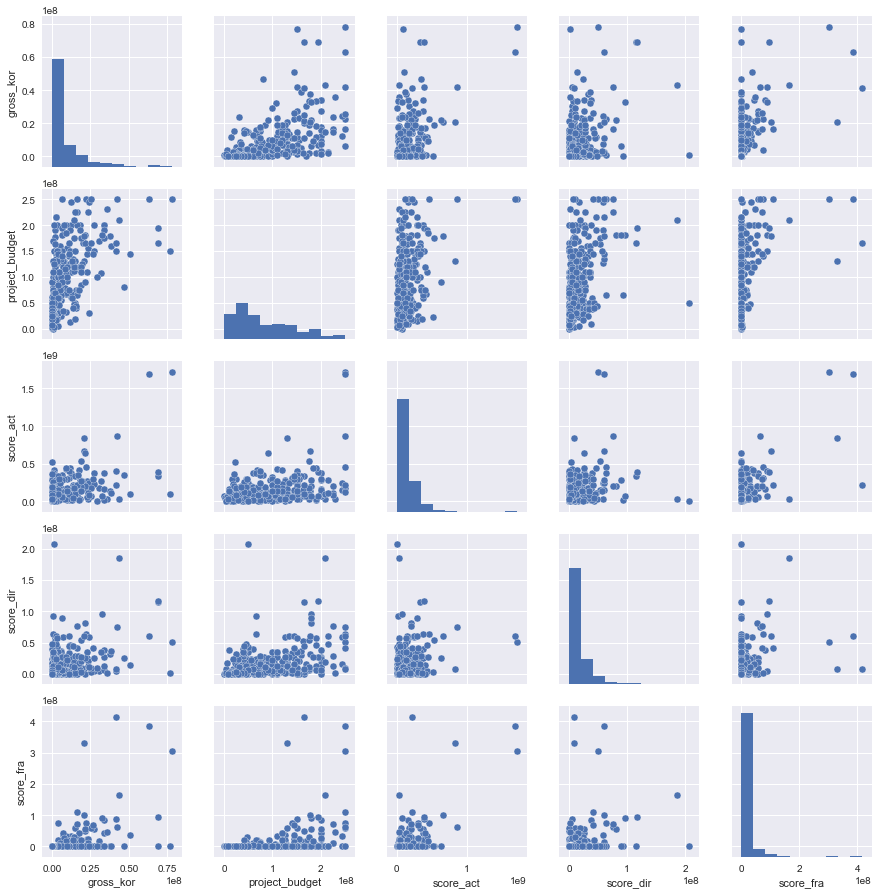

In [189]:
sns.pairplot(df_n0, vars=['gross_kor', 'project_budget', 'score_act', 'score_dir', 'score_fra'])
plt.show()

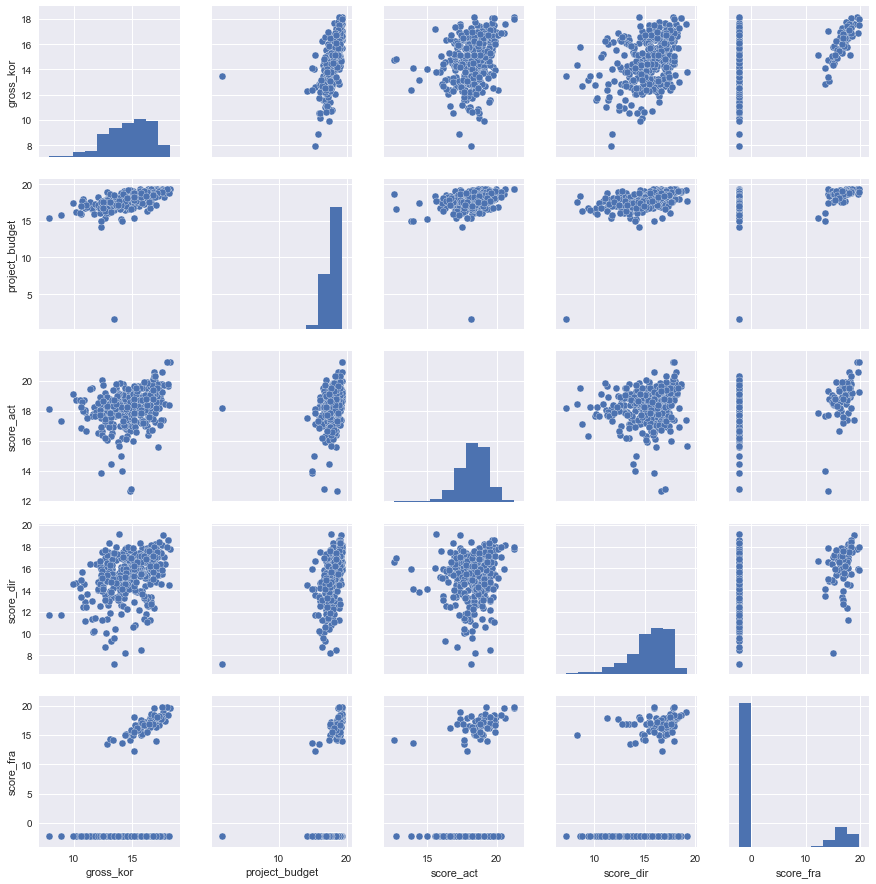

In [190]:
new_dfn = df_n0.ix[:,['gross_kor', 'project_budget', 'score_act', 'score_dir', 'score_fra']]
new_dfn['score_fra'] = np.log(new_dfn['score_fra'] + 0.1)
new_dfn['gross_kor'] = np.log(new_dfn['gross_kor'])
new_dfn['score_act'] = np.log(new_dfn['score_act'])
new_dfn['score_dir'] = np.log(new_dfn['score_dir'])
new_dfn['project_budget'] = np.log(new_dfn['project_budget'])
sns.pairplot(new_dfn)
plt.show()

In [191]:
dfx = sm.add_constant(dfx, has_constant='add')
len(dfx.columns)

32

# 1. OLS 모형 생성

In [76]:
model = sm.OLS( dfy['gross_kor'], dfx)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     12.79
Date:                Mon, 24 Apr 2017   Prob (F-statistic):           2.36e-36
Time:                        02:35:42   Log-Likelihood:                -5941.2
No. Observations:                 342   AIC:                         1.194e+04
Df Residuals:                     314   BIC:                         1.205e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.763e+06   4.47e+06     -1.

# 2. 로그 변환

In [77]:
dfx['score_act'] = np.log(dfx['score_act'])
dfx['score_dir'] = np.log(dfx['score_dir'])
dfx['score_fra'] = np.log(dfx['score_fra'] + 0.1)
dfx['project_budget'] = np.log(dfx['project_budget'])
dfy = np.log(dfy)

In [78]:
model = sm.OLS(dfy, dfx)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     10.54
Date:                Mon, 24 Apr 2017   Prob (F-statistic):           2.76e-30
Time:                        02:35:47   Log-Likelihood:                -576.14
No. Observations:                 342   AIC:                             1208.
Df Residuals:                     314   BIC:                             1316.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.3235      1.524      2.

# 3. 아웃라이어 제거

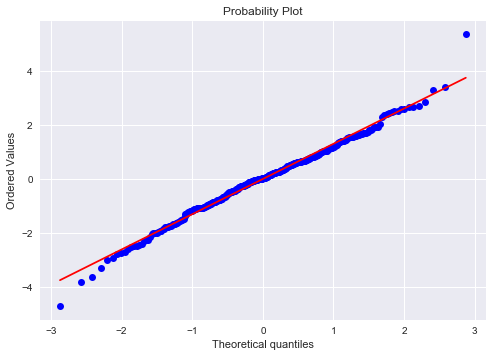

In [79]:
#아웃라이어
plt.figure()
sp.stats.probplot(result.resid, plot = plt)
plt.show()

In [80]:
influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 /float(len(dfx)-2)
idx = np.where(cooks_d2 < fox_cr)[0]
dfx2 = dfx.ix[idx,:].reset_index(drop = 1)
dfy2 = dfy.ix[idx,:].reset_index(drop = 1)

c:\python27\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [81]:
model2 = sm.OLS(dfy2['gross_kor'], dfx2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     16.61
Date:                Mon, 24 Apr 2017   Prob (F-statistic):           1.70e-43
Time:                        02:35:55   Log-Likelihood:                -470.34
No. Observations:                 320   AIC:                             994.7
Df Residuals:                     293   BIC:                             1096.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6632      1.664     -1.

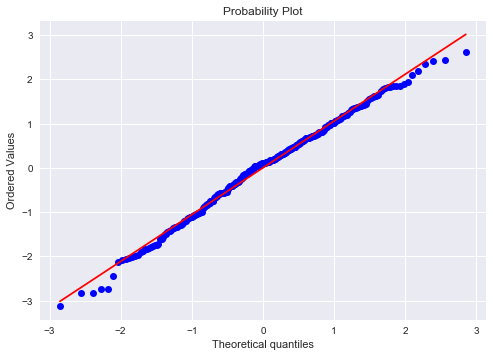

In [82]:
plt.figure()
sp.stats.probplot(result2.resid, plot = plt)
plt.show()

# 3. 스케일링

In [106]:
dfx3 = dfx2.copy()
dfy3 = dfy2.copy()

In [107]:
dfx4.columns

Index([u'project_budget',      u'score_act',      u'score_dir',
            u'score_fra',        u'Genre_0',        u'Genre_1',
              u'Genre_2',        u'Genre_3',        u'Genre_4',
              u'Genre_5',        u'Genre_6',        u'Genre_7',
              u'Genre_8',        u'Genre_9',       u'Genre_10',
             u'Genre_11',       u'Genre_12',       u'Genre_13',
             u'Genre_14',       u'Genre_15',       u'Genre_16',
             u'Genre_17',       u'Genre_18',           u'sp_d',
                 u'su_d',           u'au_d',           u'wi_d',
                       0,                12,                15,
                      18],
      dtype='object')

In [108]:
scaler = StandardScaler()
dfx4 = pd.DataFrame(scaler.fit_transform(dfx3.ix[:, 1:5]), columns=dfx3.columns[1:5])
dfy4 = pd.DataFrame(scaler.fit_transform(dfy3), columns=dfy3.columns)

In [109]:
dfx4 = dfx4.join(dfx3.reset_index(drop=1).ix[:,5:])

In [110]:
dfx4 = sm.add_constant(dfx4, has_constant='add')
dfx4.columns

Index([         u'const', u'project_budget',      u'score_act',
            u'score_dir',      u'score_fra',        u'Genre_0',
              u'Genre_1',        u'Genre_2',        u'Genre_3',
              u'Genre_4',        u'Genre_5',        u'Genre_6',
              u'Genre_7',        u'Genre_8',        u'Genre_9',
             u'Genre_10',       u'Genre_11',       u'Genre_12',
             u'Genre_13',       u'Genre_14',       u'Genre_15',
             u'Genre_16',       u'Genre_17',       u'Genre_18',
                 u'sp_d',           u'su_d',           u'au_d',
                 u'wi_d',                 0,                12,
                      15,                18],
      dtype='object')

In [112]:
model4 = sm.OLS(dfy4.reset_index(drop = 1), dfx4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     16.61
Date:                Mon, 24 Apr 2017   Prob (F-statistic):           1.70e-43
Time:                        02:40:58   Log-Likelihood:                -309.14
No. Observations:                 320   AIC:                             672.3
Df Residuals:                     293   BIC:                             774.0
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0425      0.331     -0.

# 4. 변수선택

In [211]:
dfx5 = dfx4.copy()
dfy5 = dfy4.copy()

In [114]:
#변수선택
del dfx5['Genre_0']
del dfx5['Genre_1']
del dfx5['Genre_2']
del dfx5['Genre_3']
del dfx5['Genre_4']
del dfx5['Genre_5']
del dfx5['Genre_6']
del dfx5['Genre_7']
del dfx5['Genre_8']
del dfx5['Genre_9']
del dfx5['Genre_10']
del dfx5['Genre_11']
del dfx5['Genre_12']
del dfx5['Genre_13']
del dfx5['Genre_14']
del dfx5['Genre_15']
del dfx5['Genre_16']
del dfx5['Genre_17']
del dfx5['Genre_18']
del dfx5[0]
del dfx5[12]
del dfx5[15]
#del dfx5[18]
#del dfx5['sp_d']
del dfx5['su_d']
del dfx5['au_d']
del dfx5['wi_d']
del dfx5['score_dir']
del dfx5['score_act']
#del dfx5['score_fra']
#del df5['project_budget']

In [115]:
genre = [ 
# u'\uc2a4\ub9b4\ub7ec',   #스릴러
# u'\ub4dc\ub77c\ub9c8',   #드라마
# u'\uc560\ub2c8\uba54\uc774\uc158',  #애니메이션
# u'\uc5b4\ub4dc\ubca4\ucc98',   #어드벤처 
 u'\ud310\ud0c0\uc9c0',  #판타지
# u'\ub85c\ub9e8\uc2a4/\uba5c\ub85c',  #로맨스/멜로
# u'\uc561\uc158',  #액션
# u'\ucf54\ubbf8\ub514',  #코미디 
# u'SF',   #SF
]  #뮤지컬
dummies = pd.DataFrame(np.zeros((len(dfn), len(genre))), columns=genre)
for i, gen in enumerate(dfn.genre):
    for j in gen:
        dummies.ix[i, j] = 1 /len(gen)

In [116]:
del dummies[u'가족']
#del dummies[u'시대극']
del dummies[u'전쟁']
del dummies[u'미스터리']
#del dummies[u'다큐멘터리']
del dummies[u'서부']
del dummies[u'범죄']
del dummies[u'무협']
del dummies[u'뮤지컬']
del dummies[u'공포']
del dummies[u'애니메이션']
del dummies[u'로맨스/멜로']
del dummies[u'코미디']
del dummies[u'스릴러']
del dummies[u'드라마']
del dummies[u'어드벤처']
del dummies[u'SF']
del dummies[u'액션']
#del dummies[u'판타지']

In [117]:
gen = np.arange(len(genre))
dummies.columns = gen
dfx5 = dfx5.join(dummies.add_prefix('Genre_'))

In [118]:
model4 = sm.OLS(dfy5, dfx5)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     78.59
Date:                Mon, 24 Apr 2017   Prob (F-statistic):           2.88e-53
Time:                        02:43:00   Log-Likelihood:                -324.21
No. Observations:                 320   AIC:                             660.4
Df Residuals:                     314   BIC:                             683.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.049      1.

# 교차 검증

In [148]:
X = dfx5.ix[:,1:].values
y = dfy5.values

In [149]:
model = LinearRegression()
cv = KFold(len(dfx3), n_folds=5, random_state=0)

scores = np.zeros(5)
for i, (train_index, test_index) in enumerate(cv):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[i] = r2_score(y_test, y_pred)

scores

array([ 0.3854666 ,  0.50219714,  0.58509108,  0.59548919,  0.48500093])

In [150]:
scores.mean()

0.5106489873153639

In [151]:
model = LinearRegression()
cv = KFold(len(dfx3), n_folds=5, random_state=0)

scores = np.zeros(5)
for i, (train_index, test_index) in enumerate(cv):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[i] = mean_squared_error(y_test, y_pred)
scores

array([ 0.56246893,  0.3785032 ,  0.44101883,  0.33169365,  0.60715204])

# RandomForestRegressor

In [223]:
X = dfx5.ix[:,1:]
y = dfy5['gross_kor']

In [224]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [225]:
len(X.columns)

21

In [231]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

In [232]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s : (%f)" % (f + 1, X.columns[f], importances[indices[f]]))


Feature ranking:
1. project_budget : (0.584842)
2. score_act : (0.115624)
3. score_dir : (0.080075)
4. score_fra : (0.067908)
5. Genre_2 : (0.023507)
6. Genre_3 : (0.019205)
7. Genre_4 : (0.015455)
8. Genre_6 : (0.013100)
9. Genre_8 : (0.010417)
10. Genre_12 : (0.009849)
11. Genre_13 : (0.009738)
12. Genre_15 : (0.007333)
13. Genre_17 : (0.007110)
14. sp_d : (0.006903)
15. su_d : (0.006729)
16. au_d : (0.006351)
17. wi_d : (0.005613)
18. 0 : (0.004012)
19. 12 : (0.002877)
20. 15 : (0.002342)
21. 18 : (0.001010)
